# Power comparison under different hypotheses

The goal of this notebook is to understand how different hypotheses change the power of an experiment. We start from some theory, moving to a pratical perspective using simulations and the implementations from this package. 

In hypothesis testing, various hypotheses can be examined, but the most common are:

- **Two-sided**: the effect is different from zero (commonly noted as H0: beta = 0, H1: beta != 0)
- **Less**: the effect is less than zero (H0: beta >= 0, H1: beta < 0)
- **Greater**: the effect is greater than zero (H0: beta <= 0, H1: beta > 0)


In most cases the one-sided (less or greater) p-value is half the two-sided p-value. So, if the two-sided p-value is 5%, the one-sided p-value is 2.5%. However, if the actual difference (effect) went opposite to the predicted direction, in this case the one-sided p-value equals one minus half the two-sided value. So if the two-sided p-value is 2.5%, the one-tailed p-value is 97.5%. 

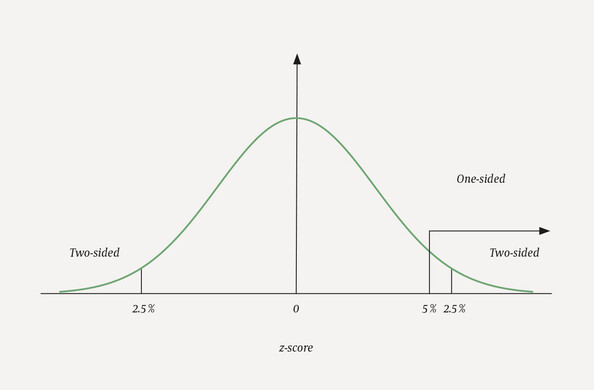

# Generate random clustered data

In [1]:
from datetime import date
import numpy as np
import pandas as pd
from ab_lab import PowerAnalysis
import matplotlib.pyplot as plt
import warnings
from plotnine import ggplot,theme_classic, facet_wrap, geom_density, labs, geom_vline, aes, geom_line, geom_histogram, geom_text,scale_y_continuous

warnings.filterwarnings('ignore')
np.random.seed(42)

N = 1000
clusters = [f"Cluster {i}" for i in range(50)]
dates = [f"{date(2022, 1, i):%Y-%m-%d}" for i in range(1, 32)]
df = pd.DataFrame(
    {
        "cluster": np.random.choice(clusters, size=N),
        "target": np.random.normal(0, 1, size=N),
        "date": np.random.choice(dates, size=N),
    }
)



# OLS

Let's start with a simple OLS model, not clustered, to understand the difference in power. We will try 2 different splitters: constant and normal

In [2]:
splitters = ['constant', 'normal']
results = []

for hypothesis in ["two-sided", "less", "greater"]:
        for splitter in splitters:
                config = {
                    "analysis": 'ols',
                    "perturbator": splitter,
                    "splitter": "non_clustered",
                    "n_simulations": 50,
                    "hypothesis": hypothesis,
                    "seed":41
                }
                pw = PowerAnalysis.from_dict(config)

                power_dict = pw.power_line(df, average_effects=list(np.linspace(0.000001, 0.5, 15)))
                power_df = pd.DataFrame(list(power_dict.items()), columns=['average_effect', 'power'])

                power_df['hypothesis'] = hypothesis
                power_df['splitter'] = splitter

                results.append(power_df)


final_df = pd.concat(results, ignore_index=True)


In [3]:
final_df.head()

,average_effect,power,hypothesis,splitter
0,0.000001,0.04,two-sided,constant
1,0.035715,0.06,two-sided,constant
2,0.071429,0.22,two-sided,constant
3,0.107144,0.40,two-sided,constant
4,0.142858,0.64,two-sided,constant


In [4]:
def plot(breakdown:str, ncol_facetting:int):
    p = (ggplot(final_df, aes(x='average_effect', y = 'power', color='hypothesis')) 
         + geom_line() 
         + theme_classic() 
         + facet_wrap(breakdown, ncol = 1))

    print(p)


We can clearly see that using the correct side (higher, as the effect is positive) increase the power of the experiment. It's also great to see such a low power in case of hypothesis 'less'.

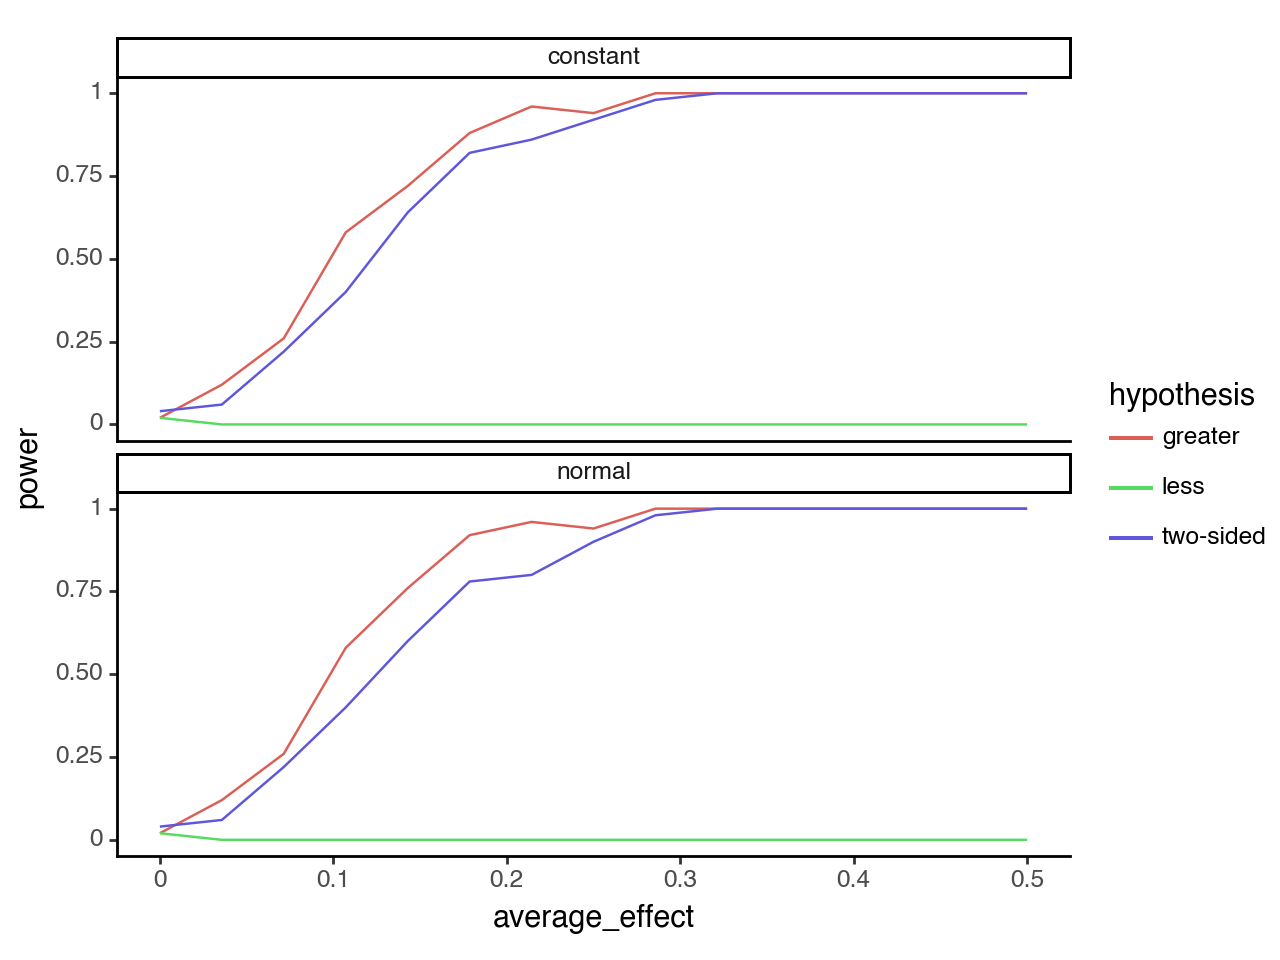

In [5]:
plot(breakdown = 'splitter', ncol_facetting = 1)

Now we will quantify this difference in power between greater and two-sided

In [6]:
pivot_df = (
    final_df
    .pivot(index = [ 'splitter', 'average_effect'], columns = 'hypothesis', values = 'power')
    .reset_index()
    .assign(diff = lambda x: x['greater'] - x['two-sided'])
)

In [7]:
mean_diff = pivot_df['diff'].mean()
max_count = np.max(pivot_df['diff'].value_counts())


Below we plot the distribution of the difference between 2-sided and 'greater' hypotheses. The mean equals to 4% is the estimated increase in power when using a one-sided experiment. From the 30 iterations, we see that 12 times it didn't change the power, in 2 cases it actually decrease it and in 2 cases the incease in power was 15pp.

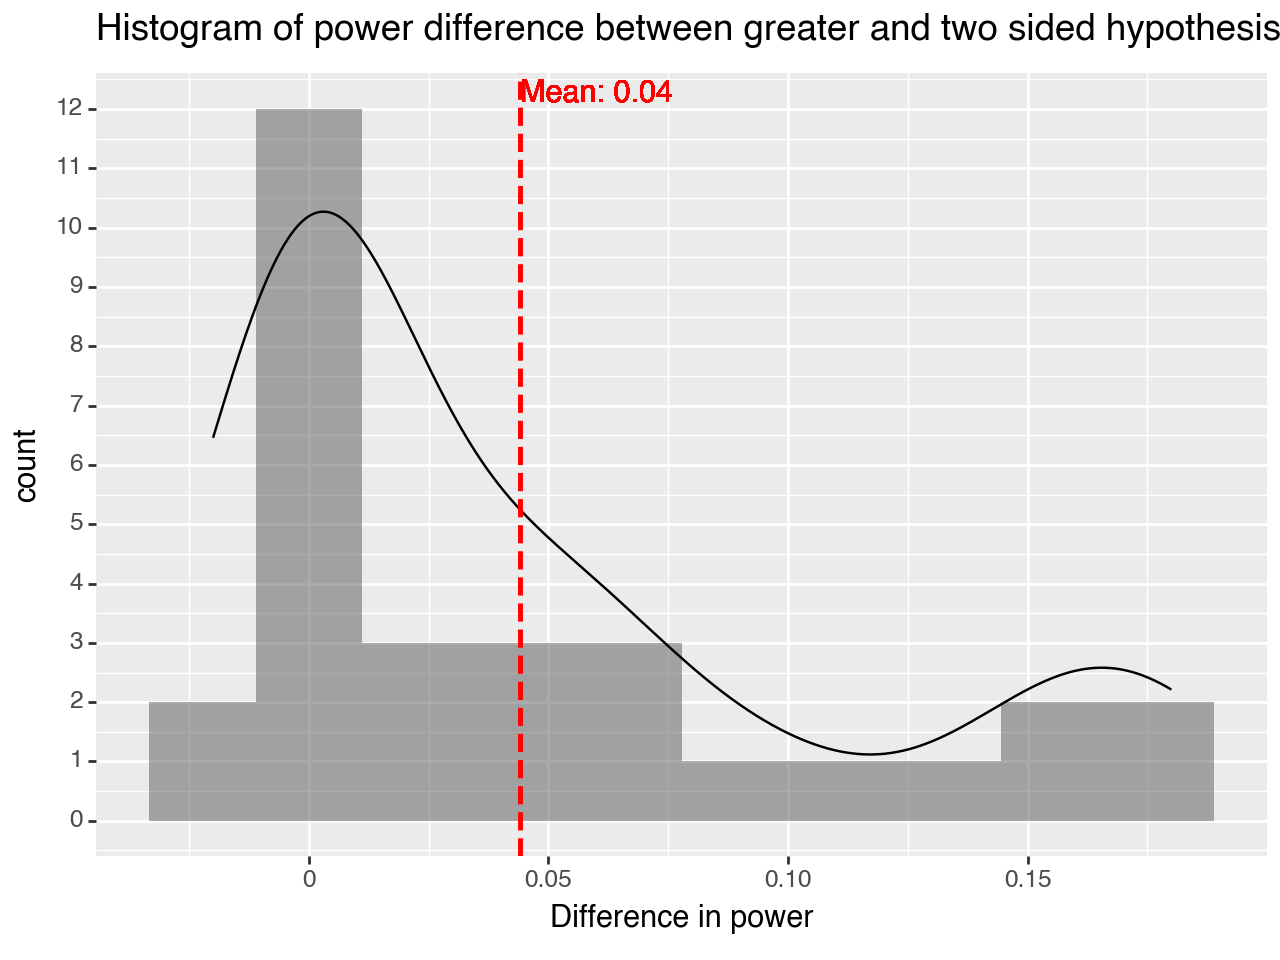

<Figure Size: (640 x 480)>

In [8]:
(ggplot(pivot_df, aes(x = 'diff')) 
 + geom_histogram( alpha=0.5, bins = 10, position="identity") 
 + geom_density()
 + geom_vline(xintercept=mean_diff, color="red", linetype="dashed", size=1)
 + geom_text(x=mean_diff, y=np.max(pivot_df['diff'].value_counts()), label=f'Mean: {mean_diff:.2f}', va='bottom', ha='left', color="red")
 + scale_y_continuous(breaks=range(0, int(max_count) + 1))
 + labs(title = 'Histogram of power difference between greater and two sided hypothesis', x='Difference in power')
        
)

# Clustered methods

Now let's move to clustered methods. To keep the notebook tidy, we will just run the constant perturbator. 

In [9]:
results = []

for hypothesis in ["two-sided", "less", "greater"]:
        for analysis in ["ols_clustered", "gee", 'ttest_clustered']:
                config = {
                    "analysis": analysis,
                    "perturbator": "constant",
                    "splitter": "clustered",
                    "n_simulations": 50,
                    "hypothesis": hypothesis,
                    "cluster_cols": ['cluster', 'date'],
                    "seed":41
                }
                pw = PowerAnalysis.from_dict(config)

                power_dict = pw.power_line(df, average_effects=list(np.linspace(0.000001, 0.5, 15)))
                power_df = pd.DataFrame(list(power_dict.items()), columns=['average_effect', 'power'])

                power_df['hypothesis'] = hypothesis
                power_df['analysis'] = analysis

                results.append(power_df)


final_df = pd.concat(results, ignore_index=True)



Here, again, we see an increase in power using the correct one-sided hypothesis compared to two-sided. 

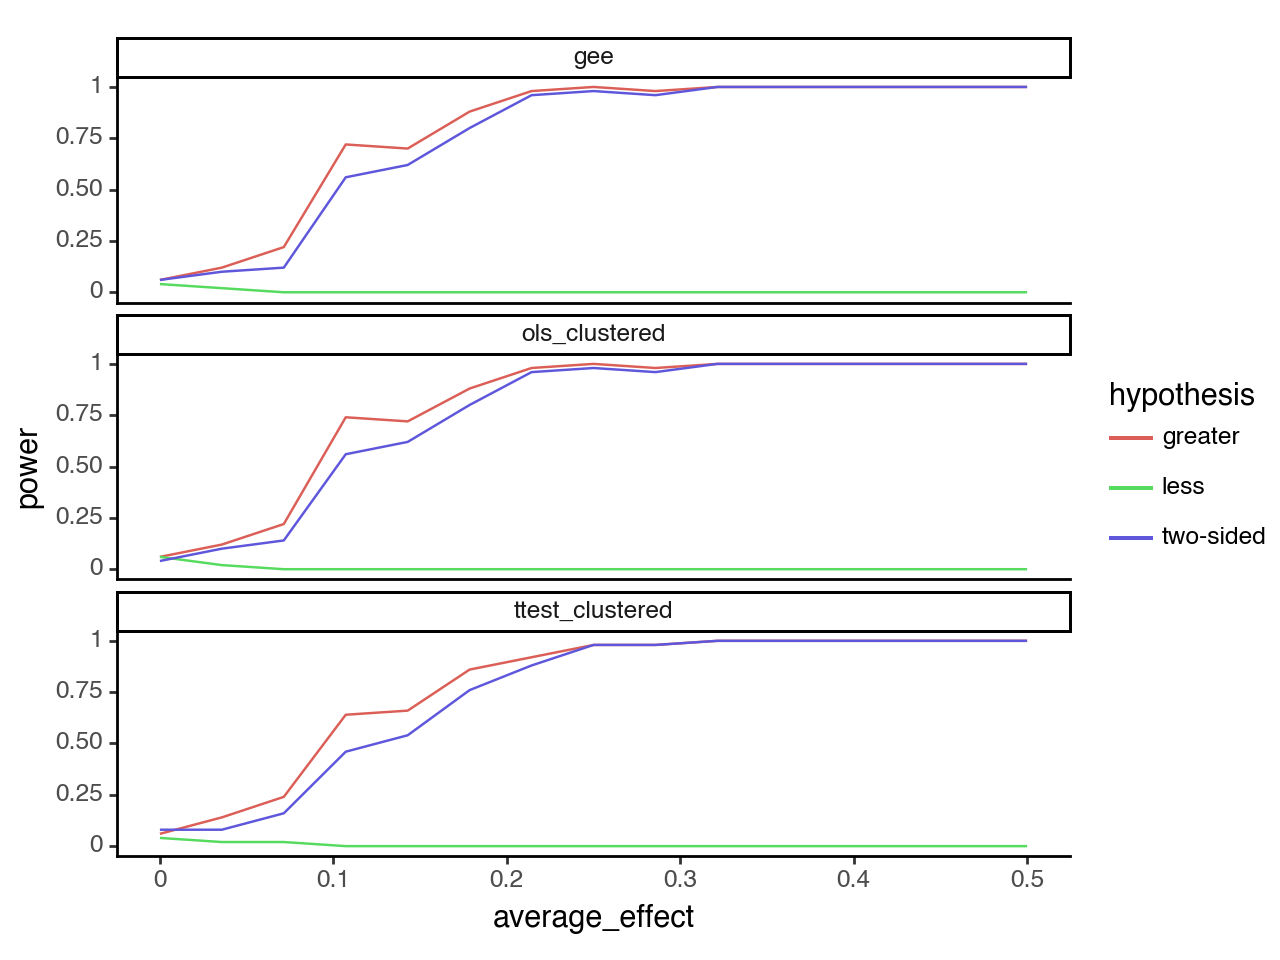

In [10]:
plot(breakdown = 'analysis', ncol_facetting=1)